In [1]:

import sys
from multiprocessing import Process
from os.path import join

sys.path.append('../')
sys.path.append('../../')

from omegaconf import OmegaConf
from src.utils.run_lib import *
from src.utils.conf_utils import * 

calib_val_frac = 0.5

root_dir = '../../'
conf_dir = f'{root_dir}configs/calib-exp/'

method = 'passive_learning'

model_ds_key = 'cifar10_med_net'

root_pfx = f'test_runs/{model_ds_key}_calib/'

base_conf                = OmegaConf.load(f'{conf_dir}/{model_ds_key}_base_conf.yaml')
base_conf['output_root'] = join(root_dir, 'outputs', root_pfx)

base_conf['eval'] = 'full'
base_conf['root_pfx'] = root_pfx
base_conf['calib_conf'] = None 


run_train_time = True   
run_post_hoc   = False 

all_outs = []

In [2]:
base_conf['method'] = method #'passive_learning' # single round
#base_conf['method'] = 'active_labeling'  # multi round
base_conf['training_conf']['weight_decay'] = 0.001
base_conf['training_conf']['learning_rate'] = 0.001
base_conf['training_conf']['max_epochs'] = 50
base_conf['training_conf']['batch_size'] = 32

base_conf['val_pts_query_conf']['max_num_val_pts'] = 1000

base_conf['train_pts_query_conf']['max_num_train_pts'] = 4000

base_conf['train_pts_query_conf']['seed_train_size'] = 4000

In [3]:
def safe_to_numpy(x):
    if(torch.is_tensor(x)):
        return x.numpy()
    else:
        return x 

In [4]:

def augment_conf(conf):
    calib_conf = conf['calib_conf']
    if(calib_conf!=None):
        conf['run_dir']        = join(conf['output_root'], calib_conf['name'])
    else:
        conf['run_dir']        = join(conf['output_root'], "None")
    
    
    if(calib_conf and (calib_conf['type']=='post_hoc')):
        ckpt_file_name = get_model_ckpt_file_name(conf)

        conf.training_conf['save_ckpt'] = True 
        conf.training_conf['train_from_scratch'] = False  
        conf.training_conf['ckpt_save_path'] = join(root_dir, 'ckpt', ckpt_file_name)
        conf.training_conf['ckpt_load_path'] = join(root_dir, 'ckpt', ckpt_file_name)

    if( calib_conf and  (calib_conf['type']=='train_time')):
        for k in  calib_conf.training_conf.keys():
            conf.training_conf[k] = calib_conf.training_conf[k]

        ckpt_file_name = get_model_ckpt_file_name(conf)

        conf.training_conf['ckpt_save_path'] = f'{root_dir}/ckpt/{ckpt_file_name}'

    conf['log_file_path']  = join(conf['run_dir'], conf['method'] + '.log')
    conf['out_file_path']  = join(conf['run_dir'], conf['method'] + '.pkl')
    conf['conf_file_path'] = join(conf['run_dir'], conf['method'] + '.yaml')

    return conf 

conf = base_conf



In [5]:
def run_conf_2(conf,pas_learn):

    overwrite = True 

    if('calib_conf' in conf and conf['calib_conf'] not in [None, "None"]):
        conf['calib_conf']['device'] = conf['device']

    if(not overwrite):
        if(os.path.exists(conf['out_file_path'])):
            print(f"path exists {conf['out_file_path']}")
    try:
        os.makedirs(conf['run_dir'])
    except OSError:
        pass

    ckpt_save_path = conf.training_conf['ckpt_save_path'] 

    if(ckpt_save_path) :
        #check if ckpt_save_path directories exist, if not create.
        ckpt_dir_path  = os.path.sep.join( ckpt_save_path.split(os.path.sep)[:-1])

        try:
            os.makedirs(ckpt_dir_path)
        except OSError:
            pass

    set_defaults(conf)

    conf['inference_conf']['device'] = conf['device']

    if('conf_file_path' in conf):
        with open(conf['conf_file_path'],'w') as f:
                OmegaConf.save(config=conf, f=f)

    logger = get_logger(conf['log_file_path'],stdout_redirect=True,level=logging.DEBUG)
    
    set_seed(conf['random_seed'])
    # get data
    dm = DataManager(conf,logger, lib=conf['model_conf']['lib'])

    logger.info('Loaded dataset {}'.format(conf['data_conf']['name']))
    logger.info(f' std_train_size : {len(dm.ds_std_train)} and  std_val_size: {len(dm.ds_std_val)}')
    
    if(not pas_learn):
        pas_learn = PassiveLearning(conf,dm,logger)

        out = pas_learn.run()

    auto_lbl_conf = conf['auto_lbl_conf']

    auto_lbl_conf['method_name']= 'selective' 

    #<<<<<<<<<<<<<<<<<<<<<<<<< BEGIN CALIBRATION BLOCK <<<<<<<<<<<<<<<<<<<<<<<<<
    cur_calibrator = None 
    if( conf['calib_conf'] and conf['calib_conf']['type']=='post_hoc'):
        calib_conf    = conf['calib_conf'] 
        logger.info('========================= Training Post-hoc Calibrator   =========================')
        
        logger.info(f"Calib Conf : {conf['calib_conf']}")

        cur_calibrator  = get_calibrator(pas_learn.cur_clf,calib_conf,logger)

        # randomly split the current available validation points into two parts.
        # one part will be used for training the calibrator and other part for finding 
        # the auto-labeling thresholds.
        dm.select_calib_val_points(calib_frac=calib_conf['calib_val_frac'])
        
        cur_val_ds_c , cur_val_idcs_c    = dm.get_cur_calib_val_ds()
        print(len(cur_val_ds_c), len(cur_val_idcs_c))
        cur_val_ds_nc , cur_val_idcs_nc    = dm.get_cur_non_calib_val_ds()

        #print(np.histogram(cur_val_ds_c.Y.numpy()))

        values, counts = np.unique(cur_val_ds_c.Y.numpy(), return_counts=True)
        print(values)
        print(counts)

        logger.info(f"Number of validation points for training calibrator : {len(cur_val_idcs_c)}")
        cur_calibrator.fit(cur_val_ds_c,ds_val_nc=cur_val_ds_nc)
    else:
        logger.info('=========================    No Post-hoc Calibration     =========================')
        cur_calibrator = None 

    #>>>>>>>>>>>>>>>>>>>>>>>>>>> END CALIBRATION BLOCK  >>>>>>>>>>>>>>>>>>>>>>>>>>>

    auto_labeler = AutoLabeling(conf,dm,pas_learn.cur_clf,logger,cur_calibrator)
    out = auto_labeler.run()
    counts_sel = dm.get_auto_labeling_counts()


    logger.info(f" Selective Auto-labeling counts: {counts_sel}")

    counts_sel['avg_ece_on_val'] =  out['ECE_on_val'] if 'ECE_on_val' in out else None
    counts_sel['avg_ece_no_calib_on_val'] = out['ECE_on_val_no_calib'] if 'ECE_on_val_no_calib' in out else None
    
    dm.unmark_auto_labeled()

    return pas_learn,cur_calibrator, dm, counts_sel

In [6]:
calib_conf = conf['calib_conf']
conf['calib_conf']      = OmegaConf.load(f'{conf_dir}/post-hoc/scaling_conf.yaml')

t_conf = conf['calib_conf']['training_conf']
t_conf['optimizer']  = 'adam'
t_conf['learning_rate'] = 0.5
t_conf['batch_size'] = 128
t_conf['weight_decay'] = 0.1
t_conf['max_epochs'] = 100

augment_conf(conf)
pl2, calib2, dm2, counts = run_conf_2(conf,None)

Files already downloaded and verified
Files already downloaded and verified
50000
50000
[01/22/2024 07:51:50 PM : DEBUG : data_manag : ] : torch.Size([40000, 3, 32, 32])
50000
50000
[01/22/2024 07:51:51 PM : INFO  : data_manag : ] : Loaded dataset cifar10
[01/22/2024 07:51:51 PM : INFO  : data_manag : ] : Std train size: 40000 and Std. Val. Size:8000
[01/22/2024 07:51:51 PM : INFO  : 996596987 : ] : Loaded dataset cifar10
[01/22/2024 07:51:51 PM : INFO  : 996596987 : ] :  std_train_size : 40000 and  std_val_size: 8000
[01/22/2024 07:51:51 PM : DEBUG : passive_le : ] : Querying 4000 seed training points
[01/22/2024 07:51:51 PM : DEBUG : passive_le : ] : Queried 4000 seed points for training
[01/22/2024 07:51:51 PM : DEBUG : passive_le : ] : Validation Data Size :1000
[01/22/2024 07:51:51 PM : DEBUG : passive_le : ] : Querying rest of the training points 0 in single batch
[01/22/2024 07:51:51 PM : INFO  : passive_le : ] : Labeled data size for training: 4000
[01/22/2024 07:51:51 PM : INF

In [7]:
dm = dm2 
pl = pl2 
calib = calib2 


In [8]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib as mpl


def visualize_scores_dist(ax, inf_out, clf=None, calibrator=None, ds=None, plot_type={}, normalize=False):
    
    if(inf_out==None):
        if(calibrator):
            inf_out = calibrator.predict(ds,inference_conf=None)
        else:
            inf_out = clf.predict(ds,inference_conf=None)
    
    
    y_hat = safe_to_numpy(inf_out['labels'])
    Y     = safe_to_numpy(inf_out['true_labels'])
    idx = np.arange(0,len(Y),1) 

    correct_idcs   = idx[y_hat==Y]
    incorrect_idcs = idx[y_hat!=Y]

    scores = safe_to_numpy(inf_out['confidence'])
    #sns.histplot(np.clip(scores[correct_idcs],0,1),ax=ax_scores_dist)
    #sns.histplot(np.clip(scores[incorrect_idcs],0,1),ax=ax_scores_dist)
    p =plot_type
    if(normalize):
        scores = scores - min(scores)
        scores = scores/max(scores)
    
    if(plot_type['name']=='hist'):
        
        
        h1, edges1 = np.histogram(scores[correct_idcs],bins=p['num_bins'],density=True, )
        h1 = h1/np.sum(h1)
        h2, edges2 = np.histogram(scores[incorrect_idcs],bins=p['num_bins'],density=True, )
        h2 = h2/np.sum(h2)
        ax.bar(edges1[1:], height=h1, width=0.01,color='blue',label='Correct') #histtype=p['histtype']
        ax.bar(edges2[1:], height=h2, width=0.01,color='red',label='Incorrect')
        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(0,max(max(h1),max(h2)))
        

    elif(plot_type['name']=='kde'):
        #sns.color_palette("hls", 8)
        sns.kdeplot(np.clip(scores[correct_idcs],0,1),ax=ax, clip=(-1,1.05), fill=p['fill'],label='Correct',linewidth=2.0,alpha=0.4)
        sns.kdeplot(np.clip(scores[incorrect_idcs],0,1),ax=ax, clip=(-1,1.05), fill=p['fill'],label='Incorrect',linewidth=2.0,alpha=0.4)
    ax.legend(loc='upper left')



36000


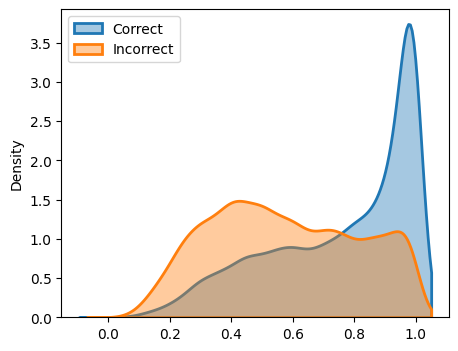

In [9]:
dm.unmark_auto_labeled()

ds_ = dm.get_subset_dataset(dm.get_current_unlabeled_idcs())
print(len(ds_))
inf_out = {}
if(calib):
    inf_out = calib.predict(ds_,inference_conf=None)
else:
    inf_out = pl.cur_clf.predict(ds_,inference_conf=None)
inf_out['true_labels'] = ds_.Y


fig, axs = plt.subplots(1, 1,figsize=(5, 4))

#cs = visualize_decision_boundary(axs[0],pl.cur_clf,calibrator=None,dm=dm)
#fig.colorbar(cs, ax=axs[0], shrink=0.9)

#visualize_scores_dist(axs, inf_out, plot_type={"name":"hist", "num_bins":15})
visualize_scores_dist(axs, inf_out, plot_type={"name":"kde","fill":True},normalize=True)

#bin_data = compute_calibration(inf_out['true_labels'], inf_out['labels'], inf_out['confidence'], num_bins=10)
#reliability_diagram_subplot(axs[2], bin_data, draw_ece=True, draw_bin_importance=False, title="Reliability Diagram", 
#                                 xlabel="Confidence", ylabel="Expected Accuracy",disable_labels=False)

#fig.colorbar(cs, ax=axs[0], shrink=0.9)
#visualize_error_cov(axs[3], inf_out, normalize=False)

In [10]:
inf_out['confidence']

tensor([0.9842, 0.3853, 0.9810,  ..., 0.6012, 0.6837, 0.6233])

In [11]:
import pickle 
with open('../../outputs/figure-2/cifar10-med-net-std-xent_Scaling_inf_out_unlbld_2.pkl',"wb") as f :
    pickle.dump(inf_out, f)

0.18333249582722783


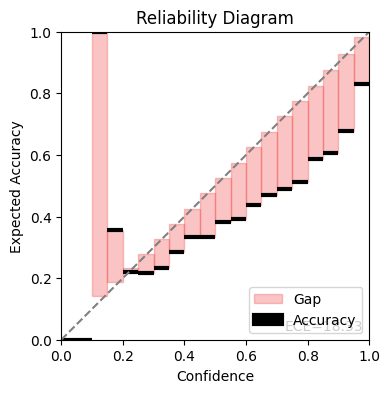

In [12]:
fig, axs = plt.subplots(1, 1,figsize=(5, 4))

bin_data = compute_calibration(inf_out['true_labels'], inf_out['labels'], inf_out['confidence'], num_bins=20)
reliability_diagram_subplot(axs, bin_data, draw_ece=True, draw_bin_importance=False, title="Reliability Diagram", 
                                 xlabel="Confidence", ylabel="Expected Accuracy",disable_labels=False)
print(bin_data['expected_calibration_error'])